In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout , Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")

In [ ]:
df.head(3)

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [ ]:
df.shape

(282, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [ ]:
df.describe()

,bytes_in,bytes_out,response.code,dst_port
count,2.820000e+02,2.820000e+02,282.0,282.0
mean,1.199390e+06,8.455429e+04,200.0,443.0
std,4.149312e+06,2.549279e+05,0.0,0.0
min,4.000000e+01,4.400000e+01,200.0,443.0
25%,5.381500e+03,1.114200e+04,200.0,443.0
50%,1.318200e+04,1.379950e+04,200.0,443.0
75%,3.083300e+04,2.627950e+04,200.0,443.0
max,2.520779e+07,1.561220e+06,200.0,443.0


In [ ]:
df_unique = df.drop_duplicates()

In [ ]:
df_unique["creation_time"] = pd.to_datetime(df_unique["creation_time"])
df_unique["end_time"] = pd.to_datetime(df_unique["end_time"])
df_unique["time"] = pd.to_datetime(df_unique["time"])

In [ ]:
df_unique["src_ip_country_code"] = df_unique["src_ip_country_code"].str.upper()

In [ ]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source.meta          2

In [ ]:
df_unique.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule


In [ ]:
df_unique["duration_seconds"] = (df_unique["end_time"] - df_unique["creation_time"]).dt.total_seconds()

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_unique[["bytes_in", "bytes_out", "duration_seconds"]])


In [ ]:
encoder = OneHotEncoder( sparse_output = False)
encoded_features = encoder.fit_transform(df_unique[["src_ip_country_code"]])


In [ ]:
scaled_columns = ["sacled_bytes_in", "scaled_bytes_out", "scaled_duration_seconds"]
encoded_columns = encoder.get_feature_names_out(["src_ip_country_code"])

In [ ]:
scaled_df = pd.DataFrame(scaled_features, columns=scaled_columns, index = df_unique.index)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=df_unique.index)

In [ ]:
transform_df = pd.concat([df_unique, scaled_df, encoded_df], axis = 1)

In [ ]:
transform_df.head(3)

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,duration_seconds,sacled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,-0.288219,-0.281223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,-0.282108,-0.260804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,-0.282689,-0.279344,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
transform_df.shape

(282, 27)

In [ ]:
num_df = transform_df.select_dtypes(include = ["int64", "float64"])

In [ ]:
correlation_matrix = num_df.corr()

In [ ]:
correlation_matrix

,bytes_in,bytes_out,response.code,dst_port,duration_seconds,sacled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
bytes_in,1.000000,0.997705,NaN,NaN,NaN,1.000000,0.997705,NaN,-0.070559,-0.081670,-0.166488,-0.095333,-0.065939,-0.006827,0.316015
bytes_out,0.997705,1.000000,NaN,NaN,NaN,0.997705,1.000000,NaN,-0.072452,-0.081777,-0.159587,-0.090001,-0.067630,-0.045641,0.327683
response.code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dst_port,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sacled_bytes_in,1.000000,0.997705,NaN,NaN,NaN,1.000000,0.997705,NaN,-0.070559,-0.081670,-0.166488,-0.095333,-0.065939,-0.006827,0.316015
scaled_bytes_out,0.997705,1.000000,NaN,NaN,NaN,0.997705,1.000000,NaN,-0.072452,-0.081777,-0.159587,-0.090001,-0.067630,-0.045641,0.327683
scaled_duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_ip_country_code_AE,-0.070559,-0.072452,NaN,NaN,NaN,-0.070559,-0.072452,NaN,1.000000,-0.069568,-0.143607,-0.081429,-0.056055,-0.064040,-0.200546
src_ip_country_code_AT,-0.081670,-0.081777,NaN,NaN,NaN,-0.081670,-0.081777,NaN,-0.069568,1.000000,-0.166091,-0.094178,-0.064831,-0.074067,-0.231945


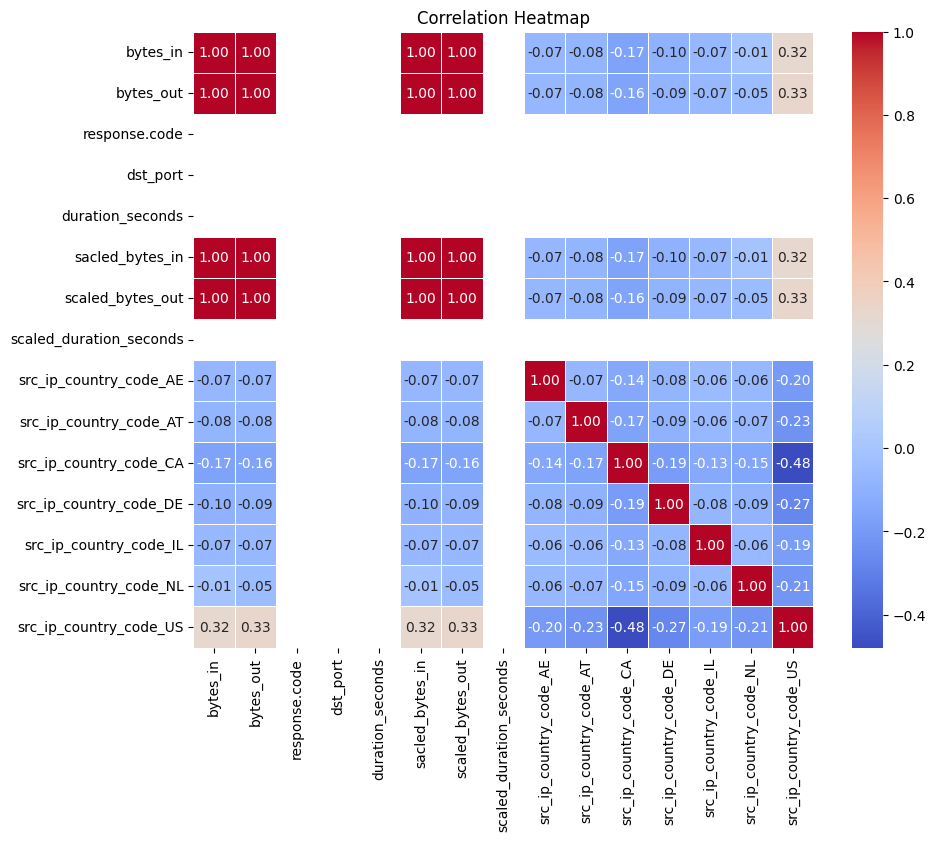

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
detection_types_by_country = pd.crosstab(transform_df["src_ip_country_code"], transform_df["detection_types"])


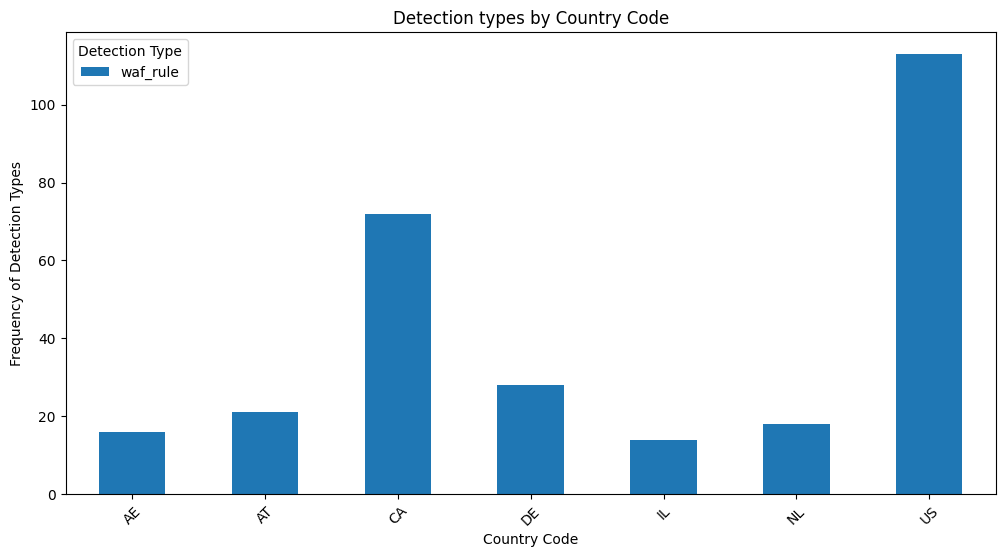

In [ ]:
detection_types_by_country.plot(kind = "bar", stacked  = True, figsize = (12,6))
plt.title("Detection types by Country Code")
plt.xlabel("Country Code")
plt.ylabel("Frequency of Detection Types")
plt.xticks(rotation = 45)
plt.legend(title = "Detection Type")
plt.show()

In [ ]:
df["creation_time"] = pd.to_datetime(df["creation_time"])

In [ ]:
df.set_index("creation_time", inplace = True)

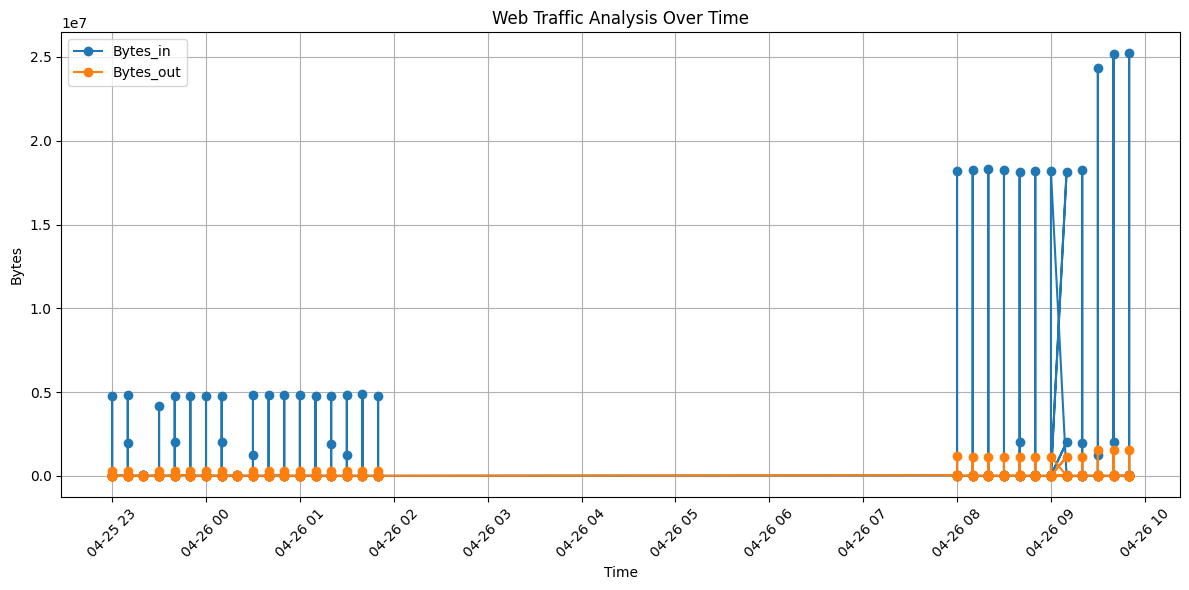

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(df.index, df["bytes_in"], label = "Bytes_in", marker = "o" )
plt.plot(df.index, df["bytes_out"], label= "Bytes_out" , marker = "o")
plt.title("Web Traffic Analysis Over Time")
plt.xlabel("Time")
plt.ylabel("Bytes")
plt.legend()
plt.grid(True)
plt.xticks(rotation =45)
plt.tight_layout()
plt.show()

In [ ]:
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_edge(row["src_ip"], row["dst_ip"])

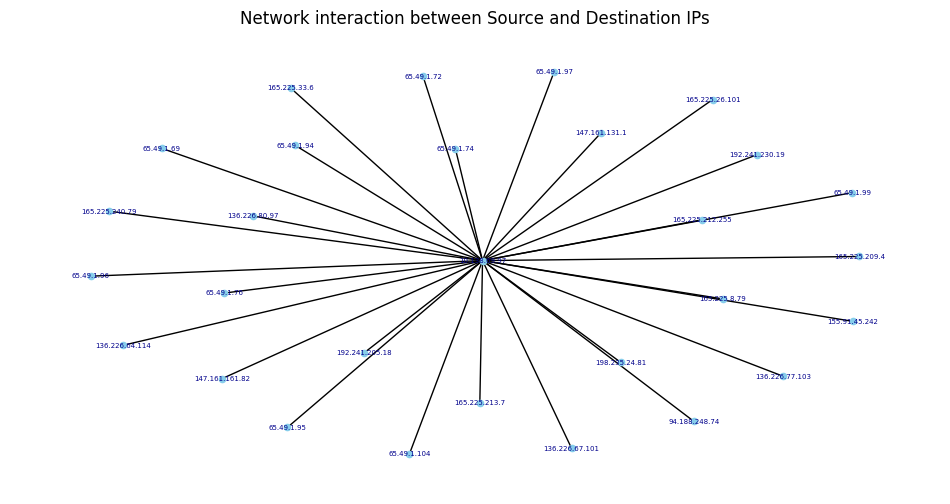

In [ ]:
plt.figure(figsize = (12,6))
nx.draw_networkx(G , with_labels= True,node_size = 20, font_size = 5, node_color = "skyblue", font_color = "darkblue")
plt.title("Network interaction between Source and Destination IPs")
plt.axis("off")
plt.show()

In [ ]:
transform_df["is_suspicious"] = (transform_df["detection_types"] == "waf_rule").astype(int)

In [ ]:
transform_df.head(2)

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,duration_seconds,sacled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US,is_suspicious
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,-0.288219,-0.281223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,-0.282108,-0.260804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [ ]:
X =transform_df[["bytes_in", "bytes_out", "scaled_duration_seconds"]]
y = transform_df["is_suspicious"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=108, random_state=42)

In [ ]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=108, random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
classification = classification_report(y_test, y_pred)
print("Classification Report:", classification)

Classification Report:               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



In [ ]:
df["is_suspicious"] = (df["detection_types"] == "waf_rule").astype(int)
X = df[["bytes_in","bytes_out"]].values
y = df["is_suspicious"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=8, verbose = 1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0132 
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0152  
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0133 
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0102  
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0138  
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0084 
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0071 
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0059  
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0064  
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0048 


In [ ]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0048  
Test Loss: 0.005201572552323341, Test Accuracy: 100.00%


In [ ]:
model= Sequential([Dense(128, activation = "relu",input_shape = (X_train_scaled.shape[1],)),Dropout(0.5),Dense(128, activation="relu"),Dropout(0.5),Dense(1, activation = "sigmoid")])

In [ ]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history= model.fit(X_train_scaled, y_train, epochs=10, batch_size=12, verbose = 1, validation_split= 0.2
                   )

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7385 - loss: 0.6658 - val_accuracy: 1.0000 - val_loss: 0.4862
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.4658 - val_accuracy: 1.0000 - val_loss: 0.2844
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.2595 - val_accuracy: 1.0000 - val_loss: 0.1147
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1080 - val_accuracy: 1.0000 - val_loss: 0.0369
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0442 - val_accuracy: 1.0000 - val_loss: 0.0142
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 1.0000 - val_loss: 0.0072
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss

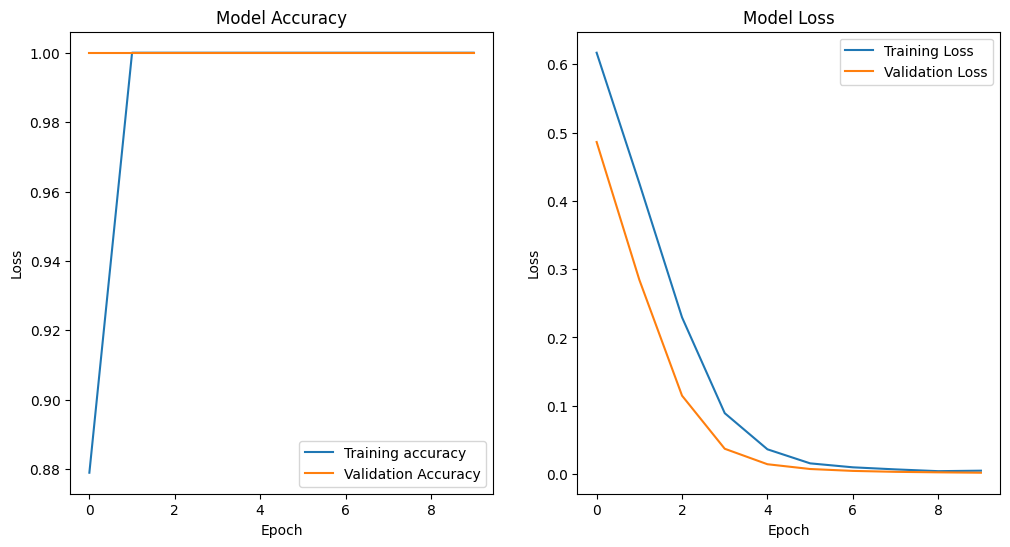

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scaler =StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.fit_transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
model = Sequential([Conv1D(32, kernel_size = 1, activation="relu",input_shape=(X_train_scaled.shape[1],1)),Flatten(),Dense(64, activation = "relu"),Dropout(0.5),Dense(1, activation = "sigmoid")])

In [ ]:
model.compile(optimizer=Adam(),loss = "binary_crossentropy",metrics= ["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs =10,batch_size=32,verbose=1,validation_split=0.2 )

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.3219 - loss: 0.7110 - val_accuracy: 1.0000 - val_loss: 0.6532
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8990 - loss: 0.6615 - val_accuracy: 1.0000 - val_loss: 0.6035
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9819 - loss: 0.6240 - val_accuracy: 1.0000 - val_loss: 0.5607
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.5884 - val_accuracy: 1.0000 - val_loss: 0.5230
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.5458 - val_accuracy: 1.0000 - val_loss: 0.4868
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.5113 - val_accuracy: 1.0000 - val_loss: 0.4481
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.4668 - val_accuracy: 1.0000 - val_loss: 0.4052
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.4258 - val_accuracy: 1.0000 - val_loss: 0.3594


In [ ]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.2919 
Test Loss: 0.2924344539642334, Test Accuracy: 100.00%


Text(0.5, 0, 'Epoch')

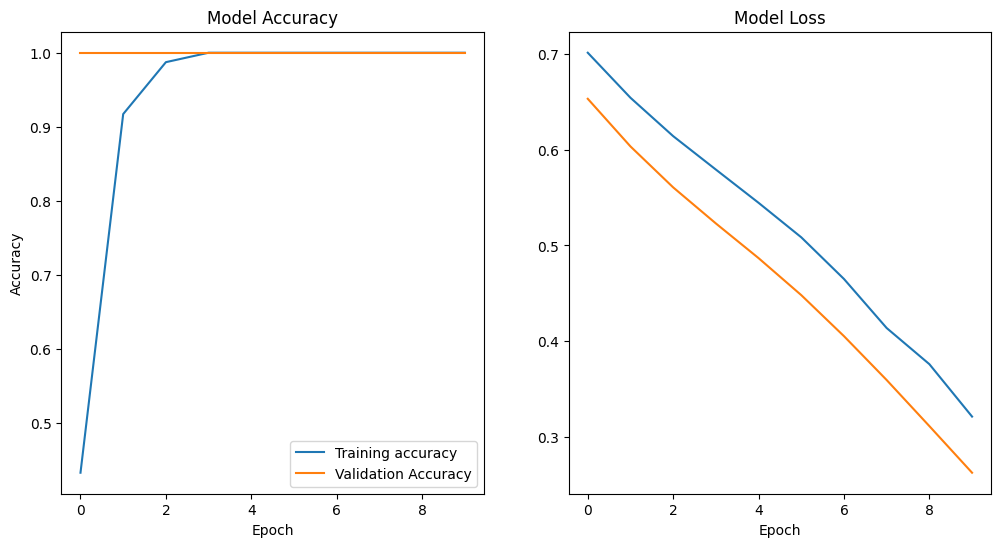

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel('Epoch')